# 2. Preprocess job descriptions

Job posting data is provided by: https://www.kaggle.com/datasets/arshkon/linkedin-job-postings

Author: Yu Kyung Koh

Last Updated: 2025/05/03

In this code, I will preprocess the descriptions before extracting information from them. This includes removing stopwords, making everything into lower case, and lemmatization.

Additionally, I will examine the most frequently occurring terms in the processed job descriptions.

In [2]:
import pandas as pd
import numpy  as np
import functools as ft
import gzip
import importlib
import json
import multiprocessing 
from joblib import Parallel, delayed
import os
import pickle
import random
import time
from symspellpy import SymSpell, Verbosity
import pkg_resources
import matplotlib.pyplot as plt
import tools
from tqdm import tqdm


## For text analyses
from collections import Counter
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
from textblob import Word

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

from symspellpy.symspellpy import SymSpell, Verbosity

/var/folders/61/4f46qg1x30s7x09xxzgv1qb40000gn/T/ipykernel_41437/3776951619.py:14: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


## SECTION 1: Examine the "combined_desc_corrected" column generated by code 2-1

"combined_desc_corrected" is the typo-corrected job descriptions generated by code 2-1. 
Here, I am going to check if "combined_desc_corrected" is inputted correctly, and if there are any visible issues with the column. 

In [4]:
## Import cleaned data from STEP 1-1
cleandatadir = '/Users/yukyungkoh/Desktop/1_Post-PhD/7_Python-projects/2_practice-NLP_job-posting_NEW/2_data/cleaned_data'
jobdata = os.path.join(cleandatadir, '1_job-posting_jobs-categorized_df.pkl')
jobs_df = pd.read_pickle(jobdata, 'zip')
print(jobs_df.head())  

       job_id                             company_name  \
0      921716                    Corcoran Sawyer Smith   
2    10998357                   The National Exemplar    
12   56482768                                      NaN   
14   69333422                          Staffing Theory   
18  111513530  United Methodists of Greater New Jersey   

                                            title  work_type  \
0                           Marketing Coordinator  FULL_TIME   
2                     Assitant Restaurant Manager  FULL_TIME   
12  Appalachian Highlands Women's Business Center  FULL_TIME   
14               Senior Product Marketing Manager  FULL_TIME   
18                 Content Writer, Communications  FULL_TIME   

    normalized_salary                                      combined_desc  \
0             38480.0  Job descriptionA leading real estate firm in N...   
2             55000.0  The National Exemplar is accepting application...   
12                NaN  FULL JOB DESCRI

In [5]:
## Check how many job postings are in this data 
len(jobs_df)

29724

In [6]:
jobs_df["combined_desc"].head(10)
## => After fixing the index option, now the combined_desc_corrected is inputted with correct job description for each row. 

0     Job descriptionA leading real estate firm in N...
2     The National Exemplar is accepting application...
12    FULL JOB DESCRIPTION – PROGRAM DIRECTOR Appala...
14    A leading pharmaceutical company committed to ...
18    Application opening date: April 24, 2024\nTitl...
22    Education Bachelor's degree in software, math,...
26    Job Description:GOYT is seeking a skilled and ...
35    About Revesco Properties:Revesco Properties is...
46    SUMMARY:Manages operation and supervises all d...
47    Gordon Partners (www.gordonpartners.com) is se...
Name: combined_desc, dtype: object

## SECTION 2: Preprocess job descriptions 

In [8]:
## (1) Lower case
jobs_df['combined_desc'] = jobs_df['combined_desc'].apply(lambda x: " ".join(x.lower()for x in x.split()))

In [9]:
## (2) Remove tabulation and punctuation
jobs_df['combined_desc'] = jobs_df['combined_desc'].str.replace(r'[^\w\s]', ' ')
    # r'[^\w\s]' matches anything that is NOT a word character or whitespace — i.e., punctuation and special symbols.

In [10]:
## (3) Remove digits
jobs_df['combined_desc'] = jobs_df['combined_desc'].str.replace(r'\d+', '')

In [11]:
## (4) Remove stop words
stop = stopwords.words('english')
jobs_df['combined_desc'] = jobs_df['combined_desc'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [12]:
## (5) Lemmatization
jobs_df['combined_desc'] = jobs_df['combined_desc'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print("Preprocessed data: \n")
print(jobs_df.head())

Preprocessed data: 

       job_id                             company_name  \
0      921716                    Corcoran Sawyer Smith   
2    10998357                   The National Exemplar    
12   56482768                                      NaN   
14   69333422                          Staffing Theory   
18  111513530  United Methodists of Greater New Jersey   

                                            title  work_type  \
0                           Marketing Coordinator  FULL_TIME   
2                     Assitant Restaurant Manager  FULL_TIME   
12  Appalachian Highlands Women's Business Center  FULL_TIME   
14               Senior Product Marketing Manager  FULL_TIME   
18                 Content Writer, Communications  FULL_TIME   

    normalized_salary                                      combined_desc  \
0             38480.0  job descriptiona leading real estate firm new ...   
2             55000.0  national exemplar accepting application assist...   
12               

In [13]:
# I also want to remove custom words like "job" or "description" from the 'combined_desc' column. 

banned_keywords = ['description', 'job', 'position', 'summary']

jobs_df['combined_desc'] = jobs_df['combined_desc'].apply(
    lambda x: " ".join(
        word for word in x.split()
        if all(bad not in word.lower() for bad in banned_keywords)
    )
)

In [14]:
#print(jobs_df.head())

## SECTION 3: Check most frequently appearing words in job descriptions by job category

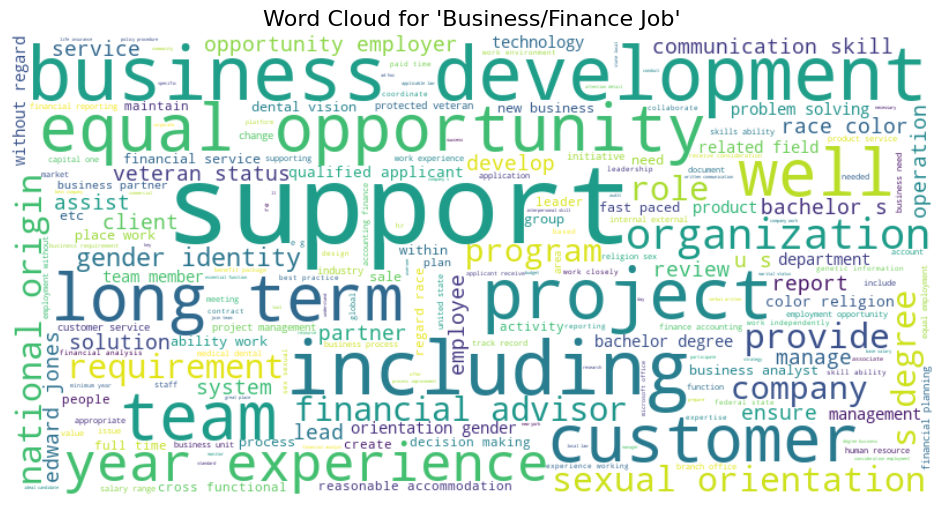

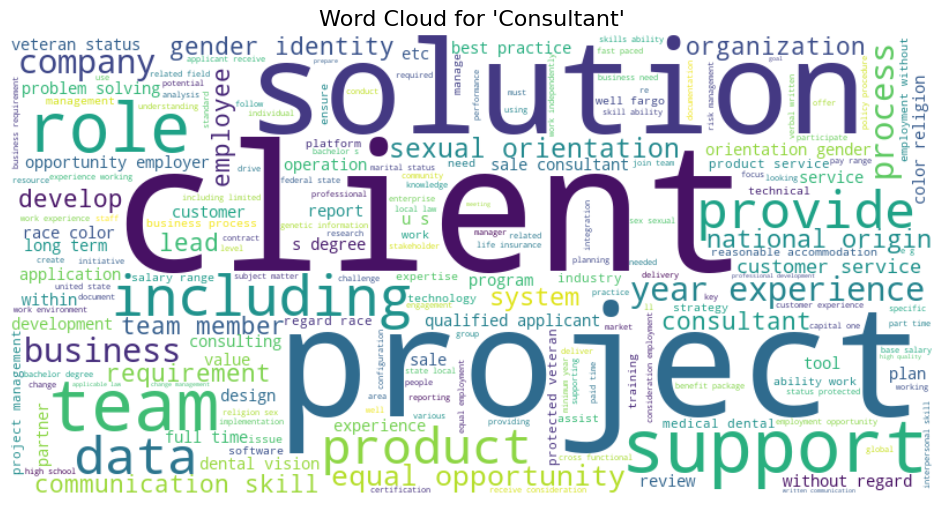

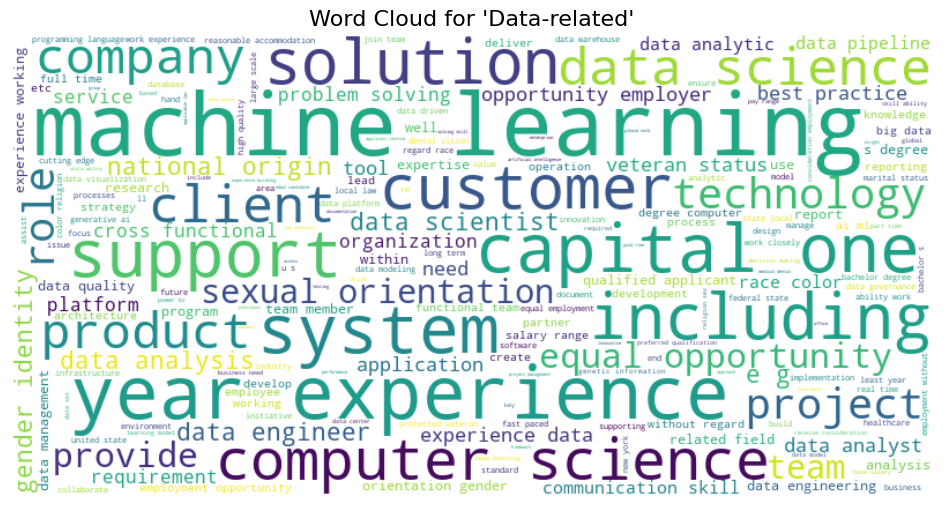

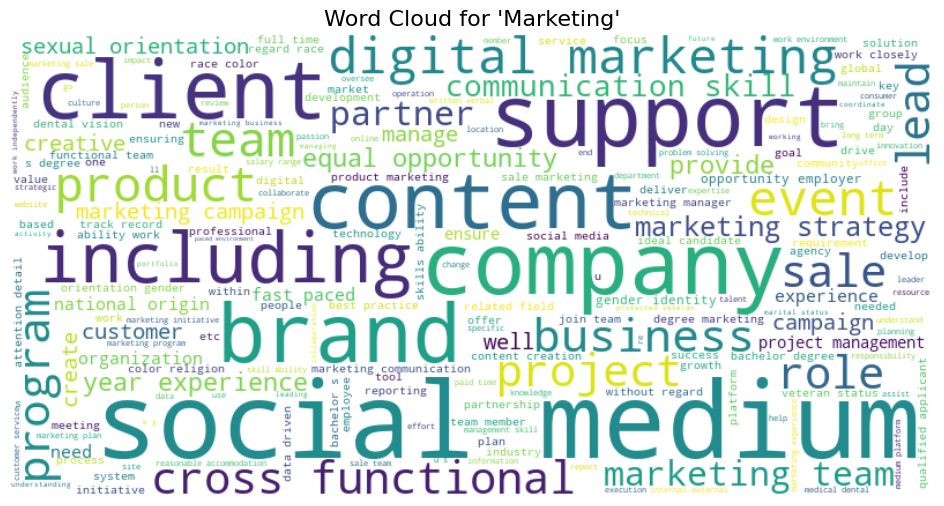

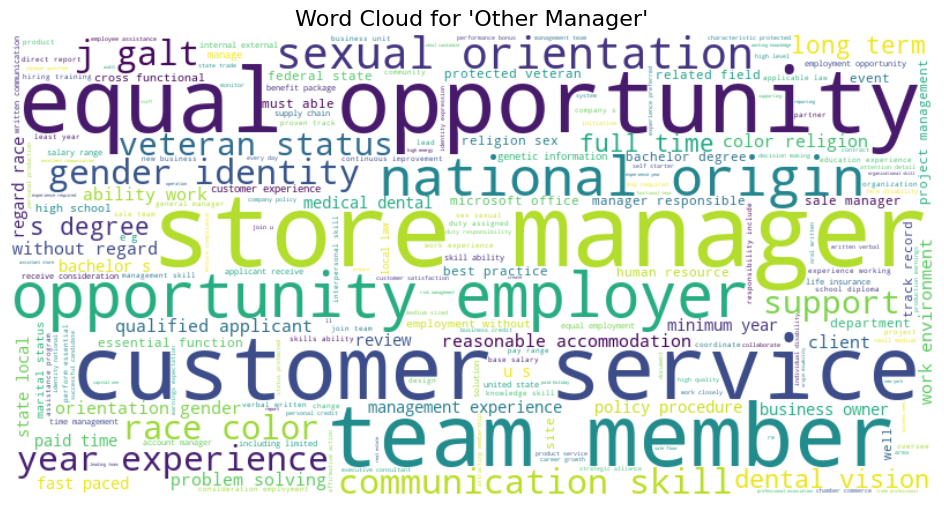

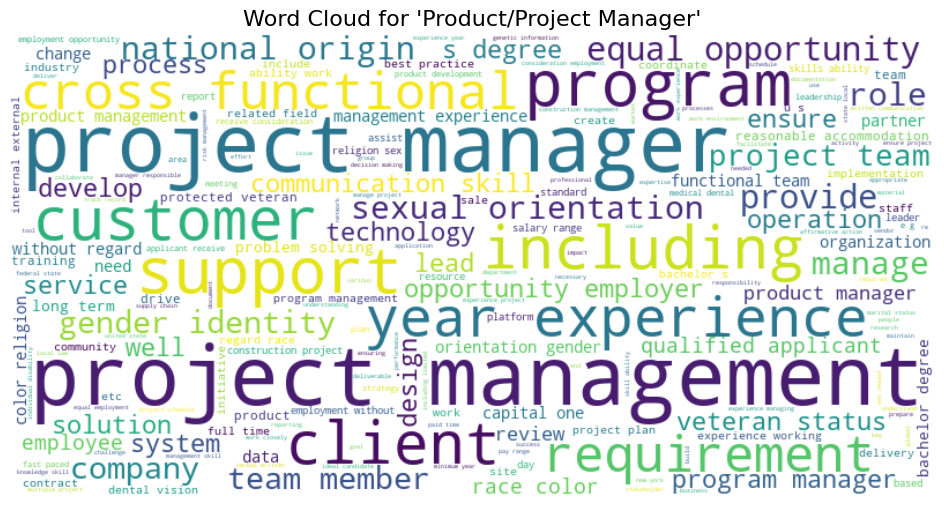

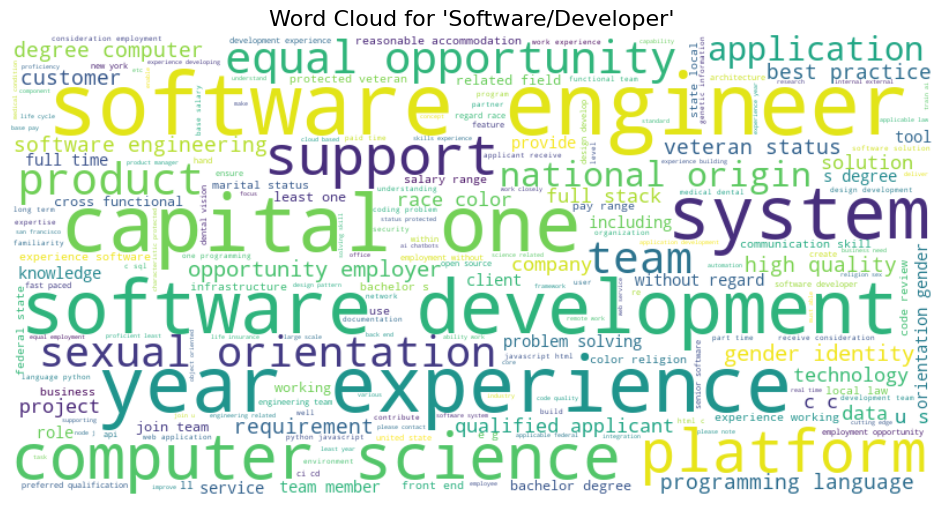

In [16]:
# Group by job category and concatenate descriptions
grouped_texts = jobs_df.groupby('job_category')['combined_desc'].apply(lambda x: ' '.join(x.dropna()))

# Loop through each category and create word clouds
for category, text in grouped_texts.items():
    if not text.strip():  # skip empty strings
        continue

    # Create and configure WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

    # Plot the WordCloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for '{category}'", fontsize=16)
    plt.show()

#### Note: 

* As shown above, word clouds do not show job skills, but a lot of unrelated texts about legal disclaimer, soft skills, diversity statements etc.

* I need to use more systematic methods to find job-relevant skills from job descriptions.

* Two broad types of machine learning I can use.

  1. Supervised learning (I need labeled data)
     * I train a model to recognize patterns using examples where the correct answer is known
     * I do need another dataset that contains job descriptions with the correct skill labels.
     * Example: I feed in
          * Input: "Must be able to use Python and SQL for data extraction"
          * Label: ["Python", "SQL"]
  3. Unsupervised learning (I do not need labeled data)
     * I don’t give the model answers — it tries to find patterns on its own.
     * Example: I give it 35,000 job descriptions, and it finds which words or phrases commonly occur together — often, those are actual job skills.

* Because I don't have labeled data, I will start with unsupervised learning.

## SECTION 4: TF-IDF 

I check whether TF-IDF helps me better identify job skills from job posting. 

What I Do:
1. Break job descriptions into phrases or bigrams (two-word phrases).
2. Count how often each phrase shows up, using a method called TF-IDF (Term Frequency-Inverse Document Frequency).
3. Keep the most important/repeated phrases — many of these will be job skills (like "project management", "data analysis").

✅ Benefits:

* Very easy to try
* No training data needed
* You can quickly get a list of top skill-related phrases per job category

❌ Limits:

* No understanding of meaning — some noise may remain
* May still include phrases like "sexual orientation" unless filtered

What happens to common phrases like "equal opportunity", "sexual orientation" that are not related to job skills? 
* Term Frequency (TF): High ✅
* Inverse Document Frequency (IDF): Low ❌ (because the phrase appears in many documents)
* ➡ TF × IDF = Low TF-IDF score overall
* ✅ TF-IDF will give these phrases low importance — exactly what you want. It is designed to **filter out** overused, non-distinctive language like equal opportunity statements

[To be deleted] Next method is "pre-trained model" that uses skills-nlp, spaCy etc. 

In [19]:
# Create an empty dictionary to hold results
category_top_terms = {}

# Loop over each unique job category
for category in jobs_df['job_category'].unique():
    print(f"Processing category: {category}")
    
    # Filter job descriptions for this category
    subset = jobs_df[jobs_df['job_category'] == category]
    texts = subset['combined_desc'].dropna().tolist()

    # Create TF-IDF Vectorizer for bigrams
    vectorizer = TfidfVectorizer(
        ngram_range=(2, 2),        # Use bigrams
        stop_words='english',      # Remove common stopwords
        max_df=0.9,                # Ignore phrases in more than 90% of documents
        min_df=5                   # Only include phrases that appear in at least 5 documents
    )

    # Fit TF-IDF model and transform the text data
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()

    # Compute the mean TF-IDF score for each bigram
    mean_tfidf = tfidf_matrix.mean(axis=0).A1

    # Get top 20 bigrams based on TF-IDF score
    top_indices = mean_tfidf.argsort()[::-1][:20]
    top_terms = [(feature_names[i], round(mean_tfidf[i], 4)) for i in top_indices]

    # Save top terms for this category
    category_top_terms[category] = top_terms

Processing category: Marketing
Processing category: Other Manager
Processing category: Business/Finance Job
Processing category: Software/Developer
Processing category: Consultant
Processing category: Product/Project Manager
Processing category: Data-related


In [20]:
# Display the results
for category, terms in category_top_terms.items():
    print(f"\nTop bigrams for category: {category}")
    for bigram, score in terms:
        print(f"  {bigram} ({score})")


Top bigrams for category: Marketing
  social medium (0.0351)
  digital marketing (0.0172)
  marketing team (0.0116)
  cross functional (0.0112)
  marketing strategy (0.011)
  sale marketing (0.0103)
  year experience (0.0102)
  bachelor degree (0.0101)
  marketing manager (0.0099)
  fast paced (0.0096)
  project management (0.0095)
  product marketing (0.0091)
  equal opportunity (0.009)
  related field (0.0087)
  marketing campaign (0.0085)
  sexual orientation (0.008)
  social media (0.008)
  national origin (0.008)
  opportunity employer (0.0078)
  communication skills (0.0078)

Top bigrams for category: Other Manager
  store manager (0.0149)
  customer service (0.0094)
  equal opportunity (0.0076)
  year experience (0.0072)
  team member (0.007)
  opportunity employer (0.0069)
  bachelor degree (0.0068)
  national origin (0.0061)
  sexual orientation (0.0061)
  long term (0.0058)
  manager responsible (0.0057)
  gender identity (0.0056)
  dental vision (0.0056)
  sale manager (0.0

#### Note: 
* Even when applying TF-IDF, top bigrams still show diversity statements like "equal opportunity", "sexual orientation", etc.
* I will come back to this later. 

In [22]:
## Save the data 
cleandatadir = '/Users/yukyungkoh/Desktop/1_Post-PhD/7_Python-projects/2_practice-NLP_job-posting_NEW/2_data/cleaned_data'
savefile = os.path.join(cleandatadir, '2_job-posting_cleaned_df.pkl')
jobs_df.to_pickle(savefile, compression='zip')